In [4]:
%load_ext autoreload
%autoreload 2

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [81]:
from utils.make_data import generate_autoregressive_forecast_dataset
from models.conformal import nonconformity, cover, ConformalForecaster

## Generate datasets

In [100]:
train_dataset = generate_autoregressive_forecast_dataset(n_samples=1000, seq_len=100, horizon=20)
calibration_dataset = generate_autoregressive_forecast_dataset(n_samples=1000, seq_len=100, horizon=20)
test_dataset = generate_autoregressive_forecast_dataset(n_samples=5000, seq_len=100, horizon=20)

## Conformal forecaster

In [101]:
model = ConformalForecaster(embedding_size=8, horizon=10, error_rate=0.05)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
from models.conformal import nonconformity, cover, ConformalForecaster
model = ConformalForecaster(embedding_size=8, horizon=10, error_rate=0.05)
model.fit(train_dataset, calibration_dataset, epochs=100, lr=0.01, batch_size=100)

In [ ]:
model.eval()
c = []
predictions = []
for sequence, target, length in test_dataset:
    sequence = sequence.unsqueeze(dim=0)
    pred = model.predict(sequence, torch.tensor([length]))
    predictions.append(pred)
    c.append(cover(pred, target))
print('% of series within predicted intervals: {}'.format(np.mean(c)))

In [37]:
for sequence, target, length in test_dataset:
    print(sequence.size(), torch.tensor([length]).size())
    break

torch.Size([100, 1]) torch.Size([1])


In [46]:
predictions[0].size()

torch.Size([1, 10, 2])

In [98]:
false_idx = np.nonzero(np.invert(c))[0]

3372
3546
3353
2833
3413
3699
1667
1675
1783
887


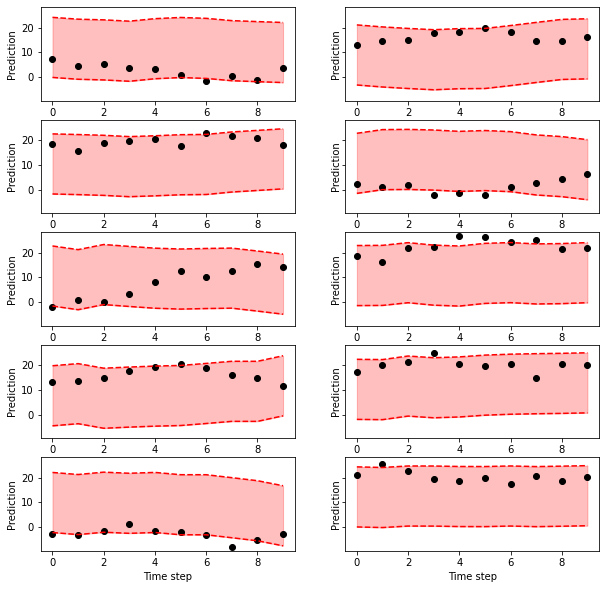

In [99]:
fig, axs = plt.subplots(5, 2, figsize=(10, 10), sharey=True)

for ax in axs.flat:
    i = np.random.choice(false_idx)
    print(i)
    ax.fill_between(range(test_dataset[i][1].size(0)),
                     predictions[i][:, 0].detach().numpy(), 
                     predictions[i][:, 1].detach().numpy(), 
                     color="r", alpha=0.25)
    ax.plot(predictions[i][:, 0].detach().numpy(), linestyle="--", color="r")
    ax.plot(predictions[i][:, 1].detach().numpy(), linestyle="--", color="r")
    # plt.plot(Y_predicted[0][0], linestyle="--", linewidth=3, color="r")

    ax.scatter(range(test_dataset[i][1].size(0)), test_dataset[i][1].detach().numpy(), color="black")
    
    ax.set(xlabel='Time step', ylabel='Prediction')

## Shorter training intervals

Set `seq_len=10` and predict for horizon of 10 time steps.

In [87]:
train_dataset_short = generate_autoregressive_forecast_dataset(n_samples=1000, seq_len=10, horizon=10)
calibration_dataset_short = generate_autoregressive_forecast_dataset(n_samples=1000, seq_len=10, horizon=10)
test_dataset_short = generate_autoregressive_forecast_dataset(n_samples=5000, seq_len=10, horizon=10)

In [88]:
model_short = ConformalForecaster(embedding_size=8, horizon=10, error_rate=0.05)

In [77]:
model_short.fit(train_dataset_short, calibration_dataset_short, epochs=100, lr=0.01, batch_size=100)
model_short.eval()
c_short = []
predictions_short = []
for sequences, target in test_dataset:
    sequences = sequences.unsqueeze(dim=0)
    out = model(sequences).squeeze()
    pred = torch.vstack([out - model.critical_calibration_scores,
                         out + model.critical_calibration_scores]).T
    predictions_short.append(pred)
    c_short.append(cover(pred, target))
print('% of series within predicted intervals: {}'.format(np.mean(c)))

NameError: name 'model_short' is not defined

In [92]:
print('% of series within predicted intervals: {}'.format(np.mean(c_short)))

% of series within predicted intervals: 0.7308


In [60]:
false_idx = np.nonzero(np.invert(c_short))[0]

fig, axs = plt.subplots(5, 2, figsize=(10, 10), sharey=True)

for ax in axs.flat:
    i = np.random.choice(false_idx)
    print(i)
    ax.fill_between(range(test_dataset[i][1].size(0)),
                     predictions[i][:, 0].detach().numpy(), 
                     predictions[i][:, 1].detach().numpy(), 
                     color="r", alpha=0.25)
    ax.plot(predictions[i][:, 0].detach().numpy(), linestyle="--", color="r")
    ax.plot(predictions[i][:, 1].detach().numpy(), linestyle="--", color="r")
    # plt.plot(Y_predicted[0][0], linestyle="--", linewidth=3, color="r")

    ax.scatter(range(test_dataset[i][1].size(0)), test_dataset[i][1].detach().numpy(), color="black")
    
    ax.set(xlabel='Time step', ylabel='Prediction')

NameError: name 'c_short' is not defined

In [63]:
pred

tensor([[ 1.5997, 18.7603],
        [ 1.6035, 18.7641],
        [ 2.0866, 19.2473],
        [ 2.1908, 19.3514],
        [ 3.2278, 20.3885],
        [ 3.6755, 20.8361],
        [ 3.7107, 20.8713],
        [ 3.6621, 20.8227],
        [ 3.7126, 20.8732],
        [ 3.5087, 20.6693]], dtype=torch.float64, grad_fn=<SqueezeBackward0>)

In [64]:
target

tensor([[19.0125],
        [17.4003],
        [16.2884],
        [16.4864],
        [13.8374],
        [14.3547],
        [15.2319],
        [15.4473],
        [15.7746],
        [15.2131]])

In [90]:
sequence, target, length = test_dataset[3008]
sequence = sequence.unsqueeze(dim=0)
out = model(sequence, torch.tensor([length]))
pred = torch.vstack([out - model.critical_calibration_scores,
                     out + model.critical_calibration_scores]).T.squeeze()
pred, target

(tensor([[-8.9004e-01,  2.3497e+01],
         [ 3.0879e-01,  2.4696e+01],
         [ 1.7650e-02,  2.4404e+01],
         [-2.9210e-01,  2.4095e+01],
         [-1.9346e-01,  2.4193e+01],
         [-1.0822e+00,  2.3304e+01],
         [-6.9688e-01,  2.3690e+01],
         [-1.5598e-01,  2.4231e+01],
         [ 4.7058e-01,  2.4857e+01],
         [ 2.0881e-01,  2.4596e+01]], dtype=torch.float64,
        grad_fn=<SqueezeBackward0>),
 tensor([[20.9468],
         [16.4516],
         [13.9279],
         [10.8415],
         [12.5514],
         [11.9186],
         [ 9.2953],
         [ 6.7622],
         [ 5.0570],
         [ 5.7807]]))

In [91]:
target.flatten() >= pred[:, 0]

tensor([True, True, True, True, True, True, True, True, True, True])

In [92]:
target.flatten() <= pred[:, 1]

tensor([True, True, True, True, True, True, True, True, True, True])

In [72]:
pred[:, 0]

tensor([ 1.1411,  0.7751, -0.1440,  0.5229,  1.0781,  1.4814,  2.7800,  2.8631,
         1.4341,  1.6738], dtype=torch.float64, grad_fn=<SelectBackward>)

In [97]:
torch.all(torch.logical_and(target.flatten() >= pred[:, 0], target.flatten() <= pred[:, 1])).item()

True

In [94]:
target.flatten() >= pred[:, 0]

tensor([True, True, True, True, True, True, True, True, True, True])

In [ ]:
target.flatten() >= pred[:, 0] and target.flatten() >= pred[:, 1]